<a href="https://colab.research.google.com/github/vinodmp4/CADD_Tutorial/blob/main/Docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## update the runtime kernel (if required)

In [ ]:
!pip install --upgrade ipykernel

## Google Colab special conda Installation


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


# Library Installation and Imports

In [ ]:
#Google Colab special openbabel Installation
%%capture
!conda install openbabel -c conda-forge
!conda install vina -c conda-forge

In [ ]:
!pip install py3Dmol

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.8 MB/s eta 0:00:00


In [ ]:
!pip install meeko

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.4/144.4 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.7 MB/s eta 0:00:00


In [ ]:
import os
import vina
import rdkit
import numpy
import shutil
import py3Dmol
import requests
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from openbabel import openbabel
from rdkit.Chem import PandasTools
from meeko import PDBQTWriterLegacy
from Bio.PDB import PDBParser, PDBIO
from meeko import MoleculePreparation
from rdkit.Chem.Draw import IPythonConsole

# Quick Taste of Molecules

[14:02:44] Molecule does not have explicit Hs. Consider calling AddHs()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

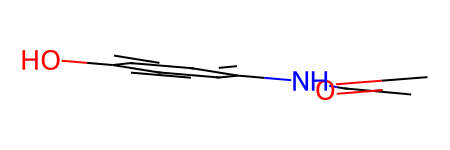

In [ ]:
paracetamol = Chem.MolFromSmiles('CC(=O)Nc1ccc(O)cc1')
AllChem.EmbedMolecule(paracetamol)
IPythonConsole.ipython_3d = True
paracetamol

[14:02:46] Molecule does not have explicit Hs. Consider calling AddHs()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

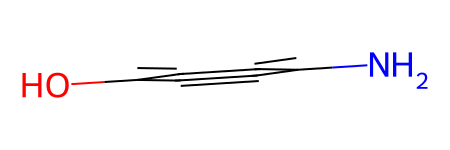

In [ ]:
Aminophenol = Chem.MolFromSmiles('c1cc(ccc1N)O') #4-aminophenol
AllChem.EmbedMolecule(Aminophenol)
IPythonConsole.ipython_3d = True
Aminophenol

<>:1: DeprecationWarning: invalid escape sequence '\C'
<>:1: DeprecationWarning: invalid escape sequence '\C'
<ipython-input-9-9395c1af68b9>:1: DeprecationWarning: invalid escape sequence '\C'
  AM404 = Chem.MolFromSmiles('O=C(Nc1ccc(O)cc1)CCC\C=C/C\C=C/C\C=C/C\C=C/CCCCC') # AM404
[14:02:46] Molecule does not have explicit Hs. Consider calling AddHs()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

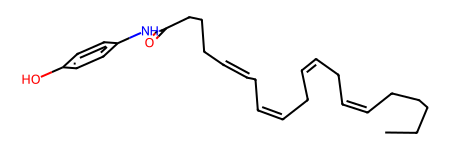

In [ ]:
AM404 = Chem.MolFromSmiles('O=C(Nc1ccc(O)cc1)CCC\C=C/C\C=C/C\C=C/C\C=C/CCCCC') # AM404
AllChem.EmbedMolecule(AM404)
IPythonConsole.ipython_3d = True
AM404

In [ ]:
view = py3Dmol.view(query='pdb:4do3',linked=False,viewergrid=(2,2)) #Fatty acid amide hydrolyse-1
view.setViewStyle({'style':'outline','color':'black','width':0.1})
view.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}},viewer=(0,1))
view.setStyle({'stick':{'colorscheme':'greenCarbon'}},viewer=(1,0))
view.setStyle({'cartoon':{'color':'spectrum'}},viewer=(1,1))
view.setStyle({'stick':{}},viewer=(0,0))
view.zoomTo(viewer=(0,0))
view.render()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

https://www.cheminfo.org/Chemistry/Cheminformatics/Smiles/index.html

#Docking

In [ ]:
DOCKING_DIR = 'DOCKING/'
if not(os.getcwd().endswith('DOCKING')):
    if not os.path.exists(DOCKING_DIR):os.makedirs(DOCKING_DIR)
    os.chdir(DOCKING_DIR)

##Prepare Ligand(s)

In [ ]:
SMILES = [['c1cc(ccc1N)O', '4-Aminophenol'],
          ['CC(=O)Nc1ccc(O)cc1','Paracetamol']
          ]
LIGANDFILENAME = 'ligands.sdf'
LIGAND_DIR = 'ligand/'

#-----------------------------------
if not os.path.exists(LIGAND_DIR):os.makedirs(LIGAND_DIR)

In [ ]:
Structures = pd.DataFrame({'SMILES': [Smile[0] for Smile in SMILES],
                           'Name': [Smile[1] for Smile in SMILES],
                           'ROMol':[Chem.MolFromSmiles(Smile[0]) for Smile in SMILES]})
if not(os.path.isfile(LIGAND_DIR+LIGANDFILENAME)):PandasTools.WriteSDF(Structures, LIGAND_DIR+LIGANDFILENAME,idName='Name')


In [ ]:
small_molecules = Chem.SDMolSupplier(LIGAND_DIR+LIGANDFILENAME, removeHs=False)
preparator = MoleculePreparation()
for index, small_molecule in enumerate(small_molecules):
    moleculename = small_molecule.GetProp('_Name')
    small_molecule = Chem.AddHs(small_molecule) # Added Hydrogens
    AllChem.EmbedMolecule(small_molecule, randomSeed=0xf00d)
    mol_setups = preparator.prepare(small_molecule)
    for setup in mol_setups:
        pdbqt_string = PDBQTWriterLegacy.write_string(setup)
        with open(LIGAND_DIR+"LIG_"+str(moleculename)+".pdbqt",'w') as outfile:
            outfile.write(pdbqt_string[0])

## Prepare Receptor


In [ ]:
RECEPTOR_ID = '4DO3'
RECEPTOR_DIR = 'receptor/'

#-----------------------------------
if not os.path.exists(RECEPTOR_DIR):os.makedirs(RECEPTOR_DIR)
link = "https://files.rcsb.org/download/"+RECEPTOR_ID.lower()+".pdb" # API from RCSB PDB
response = requests.get(link, stream=True)
with open(RECEPTOR_DIR+RECEPTOR_ID.upper()+'.pdb', "wb") as handle:
    for data in tqdm(response.iter_content()):
        handle.write(data)

791451it [00:04, 171519.88it/s]


In [ ]:
# PRE-PROCESSING 1:- Keep only ATOM records
with open(RECEPTOR_DIR+RECEPTOR_ID.upper()+'.pdb','r') as pdbfile:
    with open(RECEPTOR_DIR+'Edited_'+RECEPTOR_ID.upper()+'.pdb','w') as outfile:
        for line in pdbfile:
            if line.startswith('ATOM'):
                outfile.write(line)

In [ ]:
# PRE-PROCESSING 2:- Identify Chains
COLOURS = ['RED','GREEN','BLUE','PURPLE','CYAN','VIOLET','YELLOW']
PDBFILENAME = RECEPTOR_DIR+'Edited_'+RECEPTOR_ID.upper()+'.pdb'
pdbfile = PDBParser().get_structure(RECEPTOR_ID.upper(), PDBFILENAME)
chains = [chain.get_id().upper() for chain in pdbfile.get_chains()]
view = py3Dmol.view()
view.addModel(open(PDBFILENAME, 'r').read(),'pdb')
view.setBackgroundColor('white')
view.addSurface(py3Dmol.VDW, {'opacity':0.5, 'color':'gold'})
for index, chain in enumerate(set(chains)):
    view.setStyle({'chain':chain}, {'cartoon': {'color':COLOURS[index]}})
view.zoomTo()
print("Available Chains:", ", ".join(list(set(chains))))
view.show()

Available Chains: B, A


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# PRE-PROCESSING 3:- Confirm your Molecule
selected_molecule = RECEPTOR_DIR+'Edited_'+RECEPTOR_ID.upper()+'.pdb'
print("Index   Chain\n0       Select All")
for index, chain in enumerate(chains):
    print(index+1,"     ", chain)
selected_chain = int(input("Choose the Index of your selection "))
if selected_chain==0:pass
else:
    io=PDBIO()
    selected_chain -= 1
    if selected_chain<0:selected_chain=0
    if selected_chain>=len(chains):selected_chain = len(chain)-1
    pdbfile = PDBParser().get_structure(RECEPTOR_ID.upper(), PDBFILENAME)
    for chain in pdbfile.get_chains():
        if chain.get_id().upper() == chains[selected_chain].upper():
            io.set_structure(chain)
            selected_molecule = RECEPTOR_DIR+'Edited_'+RECEPTOR_ID.upper()+"_"+chain.get_id() + ".pdb"
            io.save(selected_molecule)
            print("Saved",'Edited_'+RECEPTOR_ID.upper()+"_"+chain.get_id() + ".pdb","file.")

Index   Chain
0       Select All
1       A
2       B
Choose the Index of your selection 1
Saved Edited_4DO3_A.pdb file.


In [ ]:
# Prepare the selected Receptor
obConversion = openbabel.OBConversion()
obConversion.SetInAndOutFormats("pdb", "pdbqt")

mol = openbabel.OBMol()
obConversion.ReadFile(mol, selected_molecule)
print("Number of residues:",mol.NumResidues())
status = obConversion.WriteFile(mol, selected_molecule+'qt')
if status:print("Conversion success")
else:print("Conversion failed")

Number of residues: 543
Conversion success


In [ ]:
# Prepare Configuration File
coords = numpy.genfromtxt(selected_molecule, skip_header=1, usecols=[6, 7, 8], skip_footer=2)
center_coords = [round(i,3) for i in list(coords.mean(axis=0))]
max_vals = [round(i,3) for i in list(coords.max(axis=0))]
distance = 0
for c, m in zip(center_coords, max_vals):
    distance = max(abs(m-c), distance)
distance = round(distance+1)
center_x, center_y, center_z = center_coords

## Actual Docking

In [ ]:
ligand_files = [i for i in os.listdir("ligand/") if i.endswith('pdbqt')]
receptor_files = [i for i in os.listdir("receptor/") if i.endswith('pdbqt')]
print("Select Ligand File\n"+'-'*40)
print("Index", " "*1, "Ligand File")
for index, lig_file in enumerate(ligand_files):
    print(index, " "*5, lig_file)
selected_lig_index = int(input("Choose the Index of your selection "))
print("\n\nSelect Receptor File\n"+'-'*40)
print("Index", " "*1, "Receptor File")
for index, rec_file in enumerate(receptor_files):
    print(index, " "*5, rec_file)
selected_rec_index = int(input("Choose the Index of your selection "))

Select Ligand File
----------------------------------------
Index   Ligand File
0       LIG_4-Aminophenol.pdbqt
1       LIG_Paracetamol.pdbqt
Choose the Index of your selection 1


Select Receptor File
----------------------------------------
Index   Receptor File
0       Edited_4DO3_A.pdbqt
Choose the Index of your selection 0


In [ ]:
RESULT_DIR = "Results/"
if not os.path.exists(RESULT_DIR):os.makedirs(RESULT_DIR)
with open(RESULT_DIR+'receptor.pdbqt', 'w') as outfile:
    with open("./receptor/"+receptor_files[selected_rec_index],'r') as inpfile:
        for line in inpfile:
            if line.startswith('ATOM') or line.startswith('REMARK'):
                outfile.write(line)
shutil.copyfile("./ligand/"+ligand_files[selected_lig_index],RESULT_DIR+"ligand.pdbqt")

'Results/ligand.pdbqt'

In [ ]:
v = vina.Vina(sf_name='vina', verbosity=0)
v.set_receptor(RESULT_DIR+'receptor.pdbqt')
v.set_ligand_from_file(RESULT_DIR+"ligand.pdbqt")
v.compute_vina_maps(center=[center_x, center_y, center_z], box_size=[distance, distance, distance])
v.write_pose(RESULT_DIR+'ligand_minimized.pdbqt', overwrite=True)
v.dock(exhaustiveness=8, n_poses=20)
v.write_poses(RESULT_DIR+'docked_ligands.pdbqt', n_poses=10, overwrite=True)
posedata = []
with open(RESULT_DIR+'docked_ligands.pdbqt','r') as dockedresult:
    for line in dockedresult:
        if line.startswith('REMARK VINA RESULT'):posedata.append(line.split()[3])

In [ ]:
print("\nLigand Pose(s) with Binding Energies\n"+'-'*40)
print("Pose", " "*7, "Binding Energy\n"+'-'*40)
for index, pose in enumerate(posedata):
    print("Pose",index+1, " "*5, pose)


Ligand Pose(s) with Binding Energies
----------------------------------------
Pose         Binding Energy
----------------------------------------
Pose 1       -5.826
Pose 2       -5.770
Pose 3       -5.560
Pose 4       -5.225
Pose 5       -5.213
Pose 6       -5.134
Pose 7       -5.109
Pose 8       -5.074
Pose 9       -5.017
Pose 10       -4.849


In [ ]:
# Write best pose to pdb
obConversion = openbabel.OBConversion()
obConversion.SetInAndOutFormats("pdbqt", "pdb")
mol = openbabel.OBMol()
obConversion.ReadFile(mol, RESULT_DIR+'docked_ligands.pdbqt')
status = obConversion.WriteFile(mol, RESULT_DIR+'best_docked_ligand.pdb')
if status:print("Ligand conversion success")
else:print("Ligand conversion failed")
mol = openbabel.OBMol()
obConversion.ReadFile(mol, RESULT_DIR+'receptor.pdbqt')
status = obConversion.WriteFile(mol, RESULT_DIR+'receptor.pdb')
if status:print("Receptor conversion success")
else:print("Receptor conversion failed")
# Merging PDB's
with open(RESULT_DIR+'complex.pdb', 'w') as complexfile:
    with open(selected_molecule,'r') as receptorfile:
        for line in receptorfile:
            if line.startswith('ATOM'):complexfile.write(line)
    with open(RESULT_DIR+'best_docked_ligand.pdb','r') as ligandfile:
        for line in ligandfile:
            if line.startswith('ATOM'):complexfile.write(line.replace('ATOM  ','HETATM'))
print("Complex file created successfully")

Ligand conversion success
Receptor conversion success
Complex file created successfully


In [ ]:
view = py3Dmol.view()
view.addModel(open(RESULT_DIR+'complex.pdb', 'r').read(),'pdb')
view.addModel(open(RESULT_DIR+'best_docked_ligand.pdb', 'r').read(),'pdb')
view.setBackgroundColor('white')
chA = {'chain':['A']}
chB = {'resn':'UNL'}
view.addSurface(py3Dmol.VDW, {'opacity':0.9, 'color':'gold'})
#view.setStyle(chA,{'cartoon': {'color':'spectrum'}})
view.setStyle(chB,{'stick': {'color':'red'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.